# SASHENIRAOD.C1 Notebook

[Click here](https://www.arm.gov/capabilities/vaps/aod) for more information about this vap.

In this notebook, we demonstrate the workflow to explore ARM vap data (using sasheniraod as an example.) Value-added products (VAPs) are higher-order data products that have been analyzed and processed to ease scientists’ use of ARM data in atmospheric research and global climate models. 
Here is the main content we will cover.

# Table of Content
## Access the data
* How to retrieve the data
* Data path and file name conventions
* Load data
## Explore the data
* NetCDF Data structure
* Xarray essentials
* Xarray Variable
## Plot the data

In [1]:
import ipywidgets as widgets

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime

import act
import xarray as xr

import random

import glob



## Access the data

### How to retrieve the data
We assume the path "/data/archive" is available where you are running this notebook. You can use `os.path.exists("/data/archive")` to verify if the path exists at your machine.


### Data path and file name conventions
There several common terminologies regarding ARM data, for example, data-stream-name, data-level, site, facility, instrument, etc. (For more details, please see [ARM Data File Standards Version 1.2](https://www.google.com/search?q=arm+datastream+facility+cite+definition&rlz=1C1GCEJ_enUS1029US1029&ei=hb41ZICrBPukqtsPvMODIA&ved=0ahUKEwjAgeiS0aL-AhV7kmoFHbzhAAQQ4dUDCBA&uact=5&oq=arm+datastream+facility+cite+definition&gs_lcp=Cgxnd3Mtd2l6LXNlcnAQAzIFCAAQogQyBQgAEKIEMgUIABCiBDIFCAAQogQyBQgAEKIEOgoIABBHENYEELADOgoIIRCgARDDBBAKSgQIQRgAUJ4DWIoOYO0PaAFwAXgAgAGMAYgBuQmSAQMyLjmYAQCgAQHIAQjAAQE&sclient=gws-wiz-serp).) 

For example, this notebook is called `sasheniraod.c1`, where `sasheniraod` is the "datastream name", and the `{process.ds_class_level}}` is the "data level".

This datastream also contains site `hou` and facility `M1`. (Note: individual datastream might have multiple site-facility pairs.)
In such a case, the data of this data-stream is stored at `/data/archive/hou/housasheniraodM1.c1`, which is in the format of `<DATA_DIR>/<site>/<site><DATASTREAM_NAME><facility>.<DATA_LEVEL>`. We can use the following method to assign the data-stream directory `datastream_dir = os.path.join(DATA_DIR, site, site + DATASTREAM_NAME + facility + '.' + DATA_LEVEL )`

The data files under datastream_dir also follows naming conventions. But once reach the datastream_dir level, the most import file naming convention to differentiate the files is "yyyyMMdd.hhmmss", which comes handy to filter out files based on datetime. For example, we can use `glob.glob(f'{datastream_dir}/*.200709*.*')` to filter files in 2007 September.

(Note: refer to the https://adc.arm.gov/discovery/#/ and https://adc.arm.gov/solr8/metadata/select API to explore ARM datastream and assoicated available sites and facilities

Please see the following examples in action

In [2]:
# Verify if DATA_DIR path exists
DATA_DIR = "/data/archive"
os.path.exists(DATA_DIR)

True

In [3]:
# Speicify datastream_dir following the path conventions and check its existence
DATASTREAM_NAME = "sasheniraod"
DATA_LEVEL = "c1"
site = "hou"
facility = "M1"
datastream_dir = os.path.join(DATA_DIR, site, site + DATASTREAM_NAME + facility + '.' + DATA_LEVEL )
print(datastream_dir)
print(os.path.exists(datastream_dir))


/data/archive/hou/housasheniraodM1.c1
True


In [4]:
# bonus: list 5 (random) files under datastream_dir
files = os.listdir(datastream_dir)
files[:5]

['housasheniraodM1.c1.20220328.121627.nc',
 'housasheniraodM1.c1.20220429.114121.nc',
 'housasheniraodM1.c1.20220521.112557.nc',
 'housasheniraodM1.c1.20220723.113628.nc',
 'housasheniraodM1.c1.20220928.121339.nc']

In [5]:
# bonus: get most recent file
list_of_files = glob.glob(f"{datastream_dir}/*") # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
latest_file

'/data/archive/hou/housasheniraodM1.c1/housasheniraodM1.c1.20220807.114517.nc'

In [6]:
# bonus sort datastream files based on datetime
files = os.listdir(datastream_dir)
file_sorted = files.copy()
file_sorted.sort()  
print(file_sorted[:5])

# to reverse
file_sorted_reverse = files.copy()  
file_sorted_reverse.sort(reverse=True)
print(file_sorted_reverse[:5])

['housasheniraodM1.c1.20210921.182544.nc', 'housasheniraodM1.c1.20210922.121916.nc', 'housasheniraodM1.c1.20210923.122004.nc', 'housasheniraodM1.c1.20210924.121059.nc', 'housasheniraodM1.c1.20210925.121133.nc']
['housasheniraodM1.c1.20221001.121521.nc', 'housasheniraodM1.c1.20220930.121513.nc', 'housasheniraodM1.c1.20220929.121412.nc', 'housasheniraodM1.c1.20220928.121339.nc', 'housasheniraodM1.c1.20220927.121628.nc']


In [7]:
# bonus: pattern matching
# filter the 200709** files under datastream_dir
files_filter = glob.glob(f'{datastream_dir}/*.200709*.*')
files_filter

[]

In [8]:
# bonus: use armnotebook_utils.file_filter (TODO) to filter files based on datastream info 


### Load data
The arm data is stored in [NetCDF](https://en.wikipedia.org/wiki/NetCDF#:~:text=%22NetCDF%20(network%20Common%20Data%20Form,format%20for%20representing%20scientific%20data.) format. We can use xarray's `open_dataset` method to load single file, or `open_mfdataset` to open multiple files. (Note: the latter will still return a single xarray dataset object by combining multiple files.)

Note: open_dataset keeps the file handle open and lazy loads its contents. All parameters are passed directly to open_dataset. It is a preferable method over load_dataset for memory-effiency. (more details, please see [xarray.open_dataset](https://docs.xarray.dev/en/stable/generated/xarray.open_dataset.html))

See the following example in action

In [9]:
# open single file
full_path = latest_file
print(full_path)
ds_single = xr.open_dataset(full_path)
ds_single

/data/archive/hou/housasheniraodM1.c1/housasheniraodM1.c1.20220807.114517.nc


<xarray.Dataset>
Dimensions:                             (time: 1559, wavelength: 241,
                                         Io_time: 44)
Coordinates:
  * time                                (time) datetime64[ns] 2022-08-07T05:4...
  * wavelength                          (wavelength) float32 902.9 ... 1.765e+03
  * Io_time                             (Io_time) datetime64[ns] 2022-07-03 ....
Data variables: (12/29)
    base_time                           datetime64[ns] ...
    time_offset                         (time) datetime64[ns] ...
    Io_values                           (Io_time, wavelength) float32 ...
    Io_values_std                       (Io_time, wavelength) float32 ...
    smoothed_Io_values                  (wavelength) float32 ...
    qc_smoothed_Io_values               (wavelength) int32 ...
    ...                                  ...
    normalized_atmospheric_variability  (time) float32 ...
    aerosol_optical_depth               (time, wavelength) float32 ...
    qc_aerosol_optical_depth            (time, wavelength) int32 ...
    lat                                 float32 ...
    lon                                 float32 ...
    alt                                 float32 ...
Attributes:
    command_line:          sasheaod -s hou -f M1 -b 20210921 -e 20221002
    Conventions:           ARM-1.1
    process_version:       vap-sasheaod-1.5-0.el7
    dod_version:           sasheniraod-c1-1.2
    input_datastreams:     housashenirhisunM1.a0 : 1.12 : 20220807.000003-202...
    site_id:               hou
    platform_id:           sasheniraod
    facility_id:           M1
    data_level:            c1
    location_description:  Tracking Aerosol Convection Interactions Experimen...
    datastream:            housasheniraodM1.c1
    history:               created by user ermold on machine prod-proc5.adc.a...

In [10]:
print(ds_single)
print(type(ds_single))

<xarray.Dataset>
Dimensions:                             (time: 1559, wavelength: 241,
                                         Io_time: 44)
Coordinates:
  * time                                (time) datetime64[ns] 2022-08-07T05:4...
  * wavelength                          (wavelength) float32 902.9 ... 1.765e+03
  * Io_time                             (Io_time) datetime64[ns] 2022-07-03 ....
Data variables: (12/29)
    base_time                           datetime64[ns] ...
    time_offset                         (time) datetime64[ns] ...
    Io_values                           (Io_time, wavelength) float32 ...
    Io_values_std                       (Io_time, wavelength) float32 ...
    smoothed_Io_values                  (wavelength) float32 ...
    qc_smoothed_Io_values               (wavelength) int32 ...
    ...                                  ...
    normalized_atmospheric_variability  (time) float32 ...
    aerosol_optical_depth               (time, wavelength) float32 ...
   

In [11]:
# open multiple files
n_files = 3
full_paths = [os.path.join(datastream_dir, f_path)  for f_path in file_sorted_reverse[:n_files]]
print(full_paths)
try: # Note: sometimes multiple files cannot be merged, so we used try except here.
    ds_mutiple = xr.open_mfdataset(full_paths)
    # ds_mutiple
    print(type(ds_mutiple))
    print(ds_mutiple)
except Exception as e:
    print(e)

['/data/archive/hou/housasheniraodM1.c1/housasheniraodM1.c1.20221001.121521.nc', '/data/archive/hou/housasheniraodM1.c1/housasheniraodM1.c1.20220930.121513.nc', '/data/archive/hou/housasheniraodM1.c1/housasheniraodM1.c1.20220929.121412.nc']
<class 'xarray.core.dataset.Dataset'>
<xarray.Dataset>
Dimensions:                             (time: 1854, wavelength: 241,
                                         Io_time: 32)
Coordinates:
  * time                                (time) datetime64[ns] 2022-09-29T06:1...
  * wavelength                          (wavelength) float32 902.9 ... 1.765e+03
  * Io_time                             (Io_time) datetime64[ns] 2022-08-28 ....
Data variables: (12/29)
    base_time                           (time) datetime64[ns] 2022-09-29T06:0...
    time_offset                         (time) datetime64[ns] dask.array<chunksize=(660,), meta=np.ndarray>
    Io_values                           (time, Io_time, wavelength) float32 dask.array<chunksize=(660, 32, 241)

## Explore the data

### NetCDF Data structure 


(If you are confident with NetCDF basics and xarray essentials, feel free to skip this session.)
Before we dive into data exploration, there are some eseential concpets we should be familiar with (shown below): 
* Dataset
* Data array
* Variable
* Dimenssion
* Coordinate
* Data Type
* Meta Data (Attributes)

We will not go into details about NetCDF basics and here are some references you might find helpful
* [Components of a NetCDF Dataset](https://iprc.soest.hawaii.edu/users/xfu/tool/guidef-7.html#)
* [Network Common Data Form (NetCDF)](https://www.unidata.ucar.edu/software/netcdf/) and [A Brief History of (netCDF) Time](https://www.unidata.ucar.edu/software/netcdf/time/recs.html)



### Xarray essentials
Earlier we introduced the xarray pacakge and used `open_dataset` and `open_mfdataset` to retrieve NetCDF data file as an xarray Dataset object. Recall that you can review the data in a notebook by using `print(ds)` or `ds`. 

Using xarray to retrieve the aforementioned NetCDF basics is straightforwared. In general,
* Dataset: `ds`
* Data array: `ds.variables`
* Variable: `ds.ds.variables`
* Dimenssion: `ds.dims`
* Coordinate: `ds.coords`
* Data Type: `type`
* Meta Data (Attributes)

Also, here are some references if you are new to xarray
* [Xarray in 45 minutes](https://tutorial.xarray.dev/overview/xarray-in-45-min.html)
* [Handling NetCDF Files using XArray for Absolute Beginners](https://towardsdatascience.com/handling-netcdf-files-using-xarray-for-absolute-beginners-111a8ab4463f)

Try the following commands in action



In [12]:
ds = ds_single

In [13]:
# Dataset 
ds

<xarray.Dataset>
Dimensions:                             (time: 1559, wavelength: 241,
                                         Io_time: 44)
Coordinates:
  * time                                (time) datetime64[ns] 2022-08-07T05:4...
  * wavelength                          (wavelength) float32 902.9 ... 1.765e+03
  * Io_time                             (Io_time) datetime64[ns] 2022-07-03 ....
Data variables: (12/29)
    base_time                           datetime64[ns] ...
    time_offset                         (time) datetime64[ns] ...
    Io_values                           (Io_time, wavelength) float32 ...
    Io_values_std                       (Io_time, wavelength) float32 ...
    smoothed_Io_values                  (wavelength) float32 ...
    qc_smoothed_Io_values               (wavelength) int32 ...
    ...                                  ...
    normalized_atmospheric_variability  (time) float32 ...
    aerosol_optical_depth               (time, wavelength) float32 ...
    qc_aerosol_optical_depth            (time, wavelength) int32 ...
    lat                                 float32 ...
    lon                                 float32 ...
    alt                                 float32 ...
Attributes:
    command_line:          sasheaod -s hou -f M1 -b 20210921 -e 20221002
    Conventions:           ARM-1.1
    process_version:       vap-sasheaod-1.5-0.el7
    dod_version:           sasheniraod-c1-1.2
    input_datastreams:     housashenirhisunM1.a0 : 1.12 : 20220807.000003-202...
    site_id:               hou
    platform_id:           sasheniraod
    facility_id:           M1
    data_level:            c1
    location_description:  Tracking Aerosol Convection Interactions Experimen...
    datastream:            housasheniraodM1.c1
    history:               created by user ermold on machine prod-proc5.adc.a...

In [14]:
# Data array, Variable
# Note: the info can be overwhelming. Do not attempt to grasp everything at the first glance.
ds.variables

Frozen({'base_time': <xarray.Variable ()>
[1 values with dtype=datetime64[ns]]
Attributes:
    string:               2022-08-07 06:00:00 0:00
    long_name:            Base time in Epoch
    ancillary_variables:  time_offset, 'time_offset': <xarray.Variable (time: 1559)>
[1559 values with dtype=datetime64[ns]]
Attributes:
    long_name:            Time offset from base_time
    ancillary_variables:  base_time, 'time': <xarray.IndexVariable 'time' (time: 1559)>
array(['2022-08-07T05:45:17.000000000', '2022-08-07T05:45:45.000000000',
       '2022-08-07T05:46:14.000000000', ..., '2022-08-07T19:06:01.000000000',
       '2022-08-07T19:06:30.000000000', '2022-08-07T19:06:59.000000000'],
      dtype='datetime64[ns]')
Attributes:
    long_name:      Time offset from start of solar day
    standard_name:  time, 'wavelength': <xarray.IndexVariable 'wavelength' (wavelength: 241)>
array([ 902.93256,  906.8547 ,  910.77496, ..., 1759.0182 , 1762.1808 ,
       1765.3389 ], dtype=float32)
Attributes:

In [15]:
# dimenssions
ds.dims

Frozen({'time': 1559, 'wavelength': 241, 'Io_time': 44})

In [16]:
# coordinates
ds.coords

Coordinates:
  * time        (time) datetime64[ns] 2022-08-07T05:45:17 ... 2022-08-07T19:0...
  * wavelength  (wavelength) float32 902.9 906.9 910.8 ... 1.762e+03 1.765e+03
  * Io_time     (Io_time) datetime64[ns] 2022-07-03 ... 2022-09-11

In [17]:
# Meta Data (Attributes)
ds.attrs

{'command_line': 'sasheaod -s hou -f M1 -b 20210921 -e 20221002',
 'Conventions': 'ARM-1.1',
 'process_version': 'vap-sasheaod-1.5-0.el7',
 'dod_version': 'sasheniraod-c1-1.2',
 'input_datastreams': 'housashenirhisunM1.a0 : 1.12 : 20220807.000003-20220808.000002\nhousashenirlangleyM1.c0 : 1.8 : 20220703.112609-20220911.120436\ngecomiX1.a1 : 1.2 : 20220801.000000-20220815.000000\nhousashevishisunM1.a0 : 1.12 : 20220807.000003-20220808.000002\nhousashevislangleyM1.c0 : 1.8 : 20220703.112609-20220911.120436',
 'site_id': 'hou',
 'platform_id': 'sasheniraod',
 'facility_id': 'M1',
 'data_level': 'c1',
 'location_description': 'Tracking Aerosol Convection Interactions Experiment (TRACER), La Porte, Texas',
 'datastream': 'housasheniraodM1.c1',
 'history': 'created by user ermold on machine prod-proc5.adc.arm.gov at 2023-09-25 19:55:40, using vap-sasheaod-1.5-0.el7'}

In [18]:
# type
print(type(ds))
print(type(ds.variables))
print(type(ds.dims))
print(type(ds.coords))
print(type(ds.attrs))

<class 'xarray.core.dataset.Dataset'>
<class 'xarray.core.utils.Frozen'>
<class 'xarray.core.utils.Frozen'>
<class 'xarray.core.coordinates.DatasetCoordinates'>
<class 'dict'>


In [19]:
# bonus: retrieve variable names only
list(ds.variables)

['base_time',
 'time_offset',
 'time',
 'wavelength',
 'Io_time',
 'Io_values',
 'Io_values_std',
 'smoothed_Io_values',
 'qc_smoothed_Io_values',
 'solar_zenith_angle',
 'cosine_solar_zenith_angle',
 'cosine_correction',
 'diffuse_correction',
 'airmass',
 'earth_sun_distance',
 'atmos_pressure',
 'qc_atmos_pressure',
 'rayleigh_optical_depth',
 'ozone_columnar_density',
 'ozone_absorption_coefficient',
 'ozone_optical_depth',
 'solar_spectrum',
 'diffuse_transmittance',
 'qc_diffuse_transmittance',
 'direct_normal_transmittance',
 'qc_direct_normal_transmittance',
 'normalized_atmospheric_variability',
 'aerosol_optical_depth',
 'qc_aerosol_optical_depth',
 'lat',
 'lon',
 'alt']

#### Discussion: variable vs. coordinates vs. dimenssions. 
From [Components of a NetCDF Dataset](https://iprc.soest.hawaii.edu/users/xfu/tool/guidef-7.html#):

* Dimession: A dimension may be used to represent a real physical dimension, for example, time, latitude, longitude, or height. A dimension might also be used to index other quantities, for example station or model-run-number.
A netCDF dimension has both a name and a length. A dimension length is an arbitrary positive integer, except that one dimension in a netCDF dataset can have the length UNLIMITED.

* Variables: Variables are used to store the bulk of the data in a netCDF dataset. A variable represents an array of values of the same type. A scalar value is treated as a 0-dimensional array. A variable has a name, a data type, and a shape described by its list of dimensions specified when the variable is created. A variable may also have associated attributes, which may be added, deleted or changed after the variable is created.

* Coordinate (Variables): It is legal for a variable to have the same name as a dimension. Such variables have no special meaning to the netCDF library. However there is a convention that such variables should be treated in a special way by software using this library.
A variable with the same name as a dimension is called a coordinate variable. It typically defines a physical coordinate corresponding to that dimension.


Tips: By definition, coordinates and dimenssions are also variable. For example ds.time is a coordinate but it is also a special variable. But in practice, when we talk about variable, it implies regular/non-coordinate variable. We will use this convention for the remaining notebook. 

### Xarray Variable


We can use `ds.variables` to access varialbes of a dataset. But many times viewing print-out the whole datasets can be overwhemling. Instead, we would work on the individual variable (also called Xarray data array.) using the `ds[var_name]` syntax, where `var_name` is the name of the variable. See the following examples in action.


In [20]:
print(type(ds["time"]))
ds["time"]

<class 'xarray.core.dataarray.DataArray'>


<xarray.DataArray 'time' (time: 1559)>
array(['2022-08-07T05:45:17.000000000', '2022-08-07T05:45:45.000000000',
       '2022-08-07T05:46:14.000000000', ..., '2022-08-07T19:06:01.000000000',
       '2022-08-07T19:06:30.000000000', '2022-08-07T19:06:59.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2022-08-07T05:45:17 ... 2022-08-07T19:06:59
Attributes:
    long_name:      Time offset from start of solar day
    standard_name:  time

#### Variable properties
For individual varible, the following properties are mostly used with the assocaited xarray method to retrieve them. (assuming var = ds[var_name])
* name: `var.name`
* data content: `var.data`
* attributes: `var.attrs`
* dimenstions: `var.dims`
* data type: `var.data.dtype`

In [21]:
var_name = "time"
var = ds[var_name]

print("var.name: \n", var.name, "\n")
print("var.data: \n", var.data, "\n")
print("var.attrs: \n", var.attrs, "\n")
print("var.dims: \n", var.dims, "\n")
print("var.data.dtype: \n", var.data.dtype, "\n")


var.name: 
 time 

var.data: 
 ['2022-08-07T05:45:17.000000000' '2022-08-07T05:45:45.000000000'
 '2022-08-07T05:46:14.000000000' ... '2022-08-07T19:06:01.000000000'
 '2022-08-07T19:06:30.000000000' '2022-08-07T19:06:59.000000000'] 

var.attrs: 
 {'long_name': 'Time offset from start of solar day', 'standard_name': 'time'} 

var.dims: 
 ('time',) 

var.data.dtype: 
 datetime64[ns] 



In [22]:
# bonus: indivdual variable info table (collect and display variable info as a tabular format)
df_info = pd.DataFrame()
df_info["var_name"] = list(ds.variables)
df_info["dims"] = df_info.var_name.apply(lambda x: ds[x].dims)
df_info["is_dim"] = df_info.var_name.apply(lambda x: x in ds.dims)
df_info["n_dim"] = df_info.var_name.apply(lambda x: len(ds[x].dims))
df_info["attrs"] = df_info.var_name.apply(lambda x: ds[x].attrs)
df_info["dtype"] = df_info.var_name.apply(lambda x: ds[x].data.dtype)
df_info

,var_name,dims,is_dim,n_dim,attrs,dtype
0,base_time,(),False,0,"{'string': '2022-08-07 06:00:00 0:00', 'long_n...",datetime64[ns]
1,time_offset,"(time,)",False,1,"{'long_name': 'Time offset from base_time', 'a...",datetime64[ns]
2,time,"(time,)",True,1,{'long_name': 'Time offset from start of solar...,datetime64[ns]
3,wavelength,"(wavelength,)",True,1,"{'long_name': 'Wavelength', 'units': 'nm'}",float32
4,Io_time,"(Io_time,)",True,1,{'long_name': 'Time offset from first Io value...,datetime64[ns]
5,Io_values,"(Io_time, wavelength)",False,2,{'long_name': 'Io values from langley regressi...,float32
6,Io_values_std,"(Io_time, wavelength)",False,2,{'long_name': 'Standard deviations of Io value...,float32
7,smoothed_Io_values,"(wavelength,)",False,1,{'long_name': 'Smoothed Io values used to comp...,float32
8,qc_smoothed_Io_values,"(wavelength,)",False,1,{'long_name': 'Quality check results on field:...,int32
9,solar_zenith_angle,"(time,)",False,1,"{'long_name': 'Apparent solar zenith angle', '...",float32


### Data cleaning/Preprocessing (skipped)
Data cleaning and preprocessing is an important stage in the the data analysis pipeline. However it will be out of the scope of this notebook. For more information about data cleaning and preprocessing basics, here are some references. 
* [Xarray Fundamentals](https://earth-env-data-science.github.io/lectures/xarray/xarray.html)
* [Xarray Tutorial — Pangeo Gallery documentation](http://gallery.pangeo.io/repos/pangeo-data/pangeo-tutorial-gallery/xarray.html)
* [Pythonic Data Cleaning With pandas and NumPy](https://realpython.com/python-data-cleaning-numpy-pandas/)
* [Pandas - Cleaning Data](https://www.w3schools.com/python/pandas/pandas_cleaning.asp)

### Plotting
Data visualization (or plotting) is another important data analysis topic and deserves its own discussion. Here in this notebook we will only demonstrate basic tool for simple data visualization tasks.

Here are some reference you might find useful:
* xarray plotting: https://docs.xarray.dev/en/stable/user-guide/plotting.html
* Atmospheric Community Toolkit (ACT): https://arm-doe.github.io/ACT/index.html

Note: this notebook is auto-generated using a template. It uses a general idea to select variable(s) to plot and is not customized to each indivdual notebook. Feel free to change the variables in intrrests, especially certain figure is failed to plot.

#### 1-dimenssional basic time series plot

For the following plot we would like to find variables such that
* it has one and only one dimession
* "time" is its coordinate variable
* it is not a dimenssion itself,
* it is not a special variable with substrings within ["time", "lat", "lon", "alt", "qc"]

Please see the following example in action. (For more details about pandas filtering, please see the following references.)
* [pandas: multiple conditions while indexing data frame](https://stackoverflow.com/questions/22591174/pandas-multiple-conditions-while-indexing-data-frame-unexpected-behavior)
* [pandas.DataFrame.apply](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html)
* [How to test if a string contains one of the substrings in a list...](https://stackoverflow.com/questions/26577516/how-to-test-if-a-string-contains-one-of-the-substrings-in-a-list-in-pandas

In [23]:
# (pandas query) filter n_dim==1, non-dimenssional, and not contains the following substrings
exclude_substrings = ["time", "lat", "lon", "alt", "qc"]
df_filter = df_info[(df_info.n_dim == 1) &
                    (df_info.dims.apply(lambda x: "time" in x)) &
                    (df_info.is_dim==False) &
                    (~df_info.var_name.str.contains('|'.join(exclude_substrings)))
                   ]
df_filter

,var_name,dims,is_dim,n_dim,attrs,dtype
9,solar_zenith_angle,"(time,)",False,1,"{'long_name': 'Apparent solar zenith angle', '...",float32
10,cosine_solar_zenith_angle,"(time,)",False,1,{'long_name': 'Cosine of apparent solar zenith...,float32
11,cosine_correction,"(time,)",False,1,"{'long_name': 'Cosine correction', 'units': 'u...",float32
13,airmass,"(time,)",False,1,{'long_name': 'Optical path length through Ear...,float32
14,earth_sun_distance,"(time,)",False,1,"{'long_name': 'Earth sun distance', 'units': '...",float32
15,atmos_pressure,"(time,)",False,1,"{'long_name': 'Atmospheric pressure', 'units':...",float32
26,normalized_atmospheric_variability,"(time,)",False,1,{'long_name': 'Normalized variability of optic...,float32


In [24]:
try:
    var_1d = df_filter.var_name.values[0]
    var_1d
except Exception as e:
    print(e) 

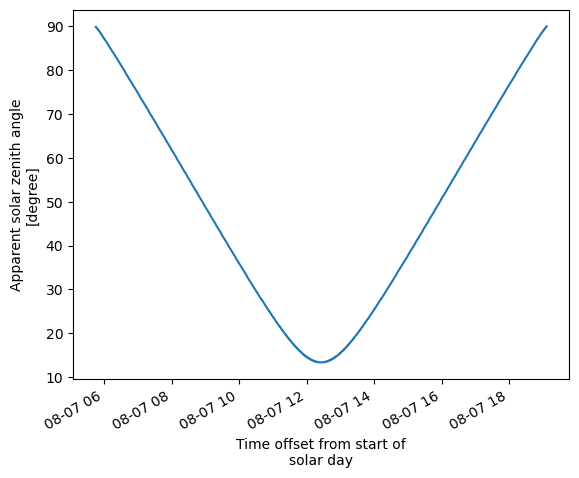

In [25]:
# Note: if failed, change to another variable to plot.
try:
    ds[var_1d].plot()
    plt.show()
except Exception as e:
    print(e)    

#### 2-dimenssional basic plot

In [26]:
# (pandas query) filter n_dim==2, non-dimenssional, and not contains the following substrings
exclude_substrings = ["time", "lat", "lon", "alt", "qc"]
df_filter_2 = df_info[(df_info.n_dim == 2) &
                      (df_info.dims.apply(lambda x: "time" in x)) &
                      (df_info.is_dim==False) &
                      (~df_info.var_name.str.contains('|'.join(exclude_substrings)))
                     ]
df_filter_2

,var_name,dims,is_dim,n_dim,attrs,dtype
22,diffuse_transmittance,"(time, wavelength)",False,2,"{'long_name': 'Diffuse transmittance', 'units'...",float32
24,direct_normal_transmittance,"(time, wavelength)",False,2,"{'long_name': 'Direct normal transmittance', '...",float32
27,aerosol_optical_depth,"(time, wavelength)",False,2,"{'long_name': 'Aerosol optical depth', 'units'...",float32


In [27]:
try:
    var_2d = df_filter_2.var_name.values[0]
    var_2d
except Exception as e:
    print(e) 

('time', 'wavelength')


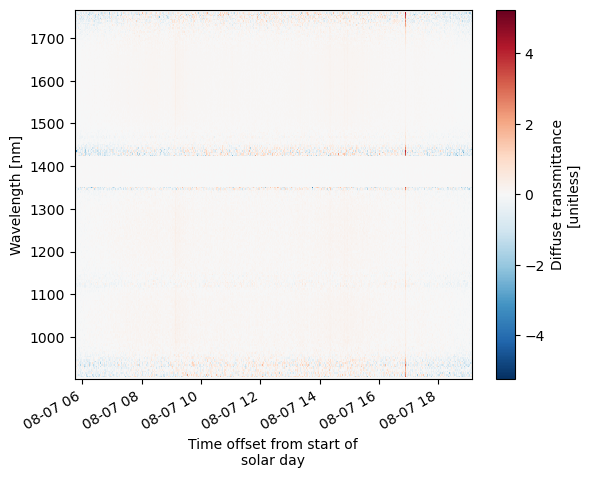

In [28]:
# Note: if failed, change to another variable to plot.
try:
    print(ds[var_2d].dims)
    # ds[var_2d].plot()

    # conventionally, use "time" as x-axis
    ds[var_2d].plot(x="time")
    plt.show()
except Exception as e:
    print(e)   

#### qc-plotting (optional)

Note: act qc plotting has more strict requirement, one of them is the associated qc variable need to have "flag_masks" attributes. Which is added by using ds = act.io.armfiles.read_netcdf(files_list), then ds.clean.cleanup()

In [29]:
try:
    ds_act = act.io.armfiles.read_netcdf(full_path)
    print(type(ds_act))
    ds_act.clean.cleanup()

    # or 
    # ds.clean.cleanup()
except Exception as e:
    print("ERROR", e)
    ds_act = ds

<class 'xarray.core.dataset.Dataset'>


In [30]:
# Filter valid variables for ACT qc plotting
condition = ("qc_" + df_info.var_name).apply(lambda x: ds_act[x].attrs.get("flag_masks") is not None 
                                             if x in list(ds.variables) else False)
exclude_substrings = ["time", "lat", "lon", "alt", "qc"]
df_filter_3 = df_info[(df_info.is_dim==False) &
                      (df_info.dims.apply(lambda x: "time" in x)) &
                      (~df_info.var_name.str.contains('|'.join(exclude_substrings))) &
                      condition
       ]
df_filter_3

,var_name,dims,is_dim,n_dim,attrs,dtype
15,atmos_pressure,"(time,)",False,1,"{'long_name': 'Atmospheric pressure', 'units':...",float32
22,diffuse_transmittance,"(time, wavelength)",False,2,"{'long_name': 'Diffuse transmittance', 'units'...",float32
24,direct_normal_transmittance,"(time, wavelength)",False,2,"{'long_name': 'Direct normal transmittance', '...",float32
27,aerosol_optical_depth,"(time, wavelength)",False,2,"{'long_name': 'Aerosol optical depth', 'units'...",float32


atmos_pressure


/home/kefeimo/.conda/envs/jupyter-vaps/lib/python3.8/site-packages/act/utils/datetime_utils.py:136: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(np.diff(time))


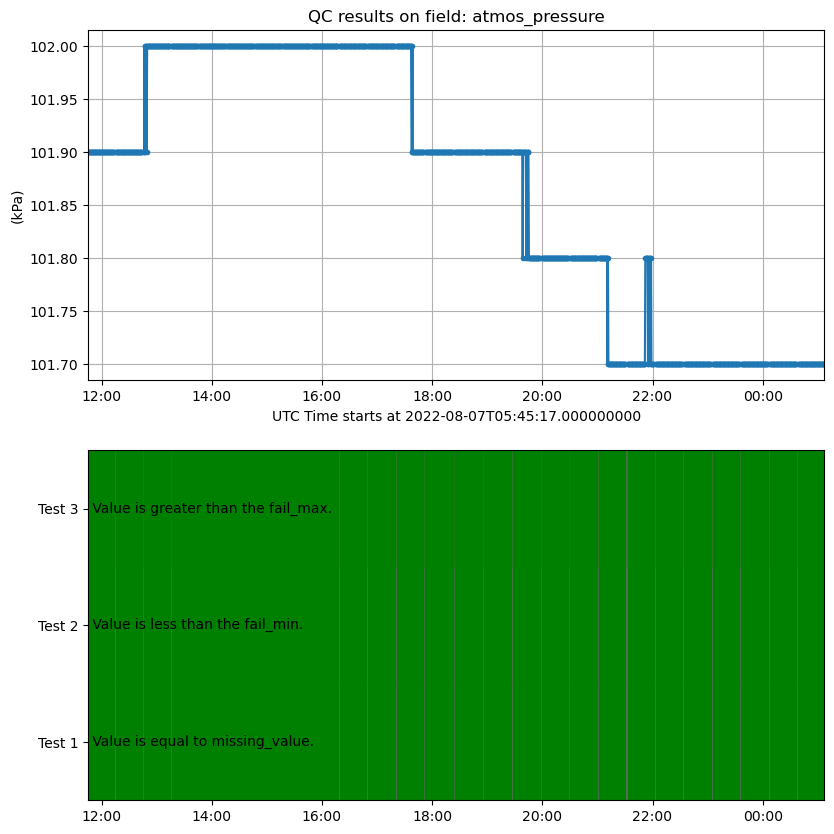

In [31]:
# QC Plot
try:
    qc_variable = df_filter_3.var_name.values[0]
    print(qc_variable)
except Exception as e:
    print(e)
    
try:

    # Plot
    qc_display = act.plotting.TimeSeriesDisplay(ds_act)
    qc_display.add_subplots((2,), figsize = (9.5,10))
    qc_ax = qc_display.plot(qc_variable, subplot_index=(0,), set_title="QC results on field: " + qc_variable,)
    qc_ax.grid()
    qc_display.qc_flag_block_plot(qc_variable, subplot_index=(1,))
    qc_ax.set_xlabel(f"UTC Time starts at {ds.time.data[0]}")

    plt.show()
except Exception as e:
    print(e)

#### bonus: choose variables to plot from a dropdown menu 

In [32]:
# Valid variables filtering
exclude_substrings = ["time", "lat", "lon", "alt", "qc"]
df_filter_4 = df_info[(df_info.is_dim==False) &
                      (df_info.dims.apply(lambda x: "time" in x)) &
                      (~df_info.var_name.str.contains('|'.join(exclude_substrings)))
                     ]
df_filter_4

,var_name,dims,is_dim,n_dim,attrs,dtype
9,solar_zenith_angle,"(time,)",False,1,"{'long_name': 'Apparent solar zenith angle', '...",float32
10,cosine_solar_zenith_angle,"(time,)",False,1,{'long_name': 'Cosine of apparent solar zenith...,float32
11,cosine_correction,"(time,)",False,1,"{'long_name': 'Cosine correction', 'units': 'u...",float32
13,airmass,"(time,)",False,1,{'long_name': 'Optical path length through Ear...,float32
14,earth_sun_distance,"(time,)",False,1,"{'long_name': 'Earth sun distance', 'units': '...",float32
15,atmos_pressure,"(time,)",False,1,"{'long_name': 'Atmospheric pressure', 'units':...",float32
22,diffuse_transmittance,"(time, wavelength)",False,2,"{'long_name': 'Diffuse transmittance', 'units'...",float32
24,direct_normal_transmittance,"(time, wavelength)",False,2,"{'long_name': 'Direct normal transmittance', '...",float32
26,normalized_atmospheric_variability,"(time,)",False,1,{'long_name': 'Normalized variability of optic...,float32
27,aerosol_optical_depth,"(time, wavelength)",False,2,"{'long_name': 'Aerosol optical depth', 'units'...",float32


In [33]:
# example 1: using xarray plot

# Uncomment the following cell to try the interactive plot (ctrl + /)

In [34]:
# %matplotlib widget
# plt.clf()

# fig, ax = plt.subplots(figsize=(10, 4))

# available_variables = df_filter_4.var_name.values
# @widgets.interact(var=available_variables)
# def update(var = available_variables[0]):
#     fig.clear() # Remove old lines from plot and plot new one
#     if len(ds[var].dims)==2:
#         ds[var].plot(x="time", add_colorbar=False)
#     else:
#         ds[var].plot()
#     plt.grid()
#     plt.show()

In [35]:
# example 2: using act plot

# Uncomment the following cell to try the interactive plot (ctrl + /)

In [36]:
# %matplotlib widget
# plt.clf()

# available_variables = df_filter_4.var_name.values


# @widgets.interact(var=available_variables)
# def update(var = available_variables[0]):

#     i_display = act.plotting.TimeSeriesDisplay(ds_act)
#     i_display.add_subplots((1,), figsize=(10, 4))
#     ax = i_display.plot(var, subplot_index=(0,), set_title=f"{var} ({ds_act[var].attrs['long_name']})",)

#     ax.set_xlabel(f"UTC Time starts at {ds.time.data[0]}")
#     ax.grid()
#     plt.show()
